In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import median_absolute_error, make_scorer

from sklearn.model_selection import cross_validate, KFold
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LogisticRegression, RidgeCV, PassiveAggressiveRegressor, SGDRegressor, Perceptron, LinearRegression, TheilSenRegressor, HuberRegressor, RANSACRegressor, Lasso, ElasticNet, Lars, LassoLars, OrthogonalMatchingPursuit, BayesianRidge, ARDRegression, TweedieRegressor, PoissonRegressor, GammaRegressor, LassoLars
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn import svm

from sklearn.base import BaseEstimator, RegressorMixin
import tensorflow as tf
import tensorflow_probability as tfp

import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

experiment = 'add_pre_randomforest_model'

import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
artificial = pd.read_csv('Artificial_Crystals_Dataset.csv')
mineral = pd.read_csv('Mineral_Dataset_Supplementary_Info.csv')
test = pd.read_csv('test.csv')

train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [3]:
# Rename hardness in artifical dataset and drop columns not required
artificial.rename(columns={'Hardness (Mohs)': 'Hardness'}, inplace=True)
artificial.drop(['Formula', 'Crystal structure', 'Unnamed: 0'], axis=1, inplace=True)

artificial.head()

,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,4.5,167.0,23.907992,18.555556,5.000000,41.609136,11.693844,2.938889,1.711111,0.884444,0.477830,2.656444
1,4.0,14.0,1.740168,4.666667,1.333333,8.773227,11.614333,1.903333,1.310000,0.680000,0.825990,0.580056
2,2.5,102.0,8.511159,4.434783,3.304348,8.440584,13.176622,2.672609,1.379130,0.530870,0.713850,0.370050
3,5.5,78.0,8.109328,13.000000,5.333333,27.448814,11.826400,2.960000,1.625000,0.813333,0.488163,1.351555
4,6.5,164.0,19.921324,14.909091,5.090909,32.012361,11.255573,2.881818,1.640909,0.841818,0.483480,1.811029


In [4]:
# Drop unneeded columns
mineral.drop('Unnamed: 0', axis=1, inplace=True)

mineral.head()

,Hardness,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,2.3,110.0,23.000000,36.666667,2.666667,82.598467,8.504133,2.146667,2.006667,1.253333,0.456803,7.666667
1,5.5,406.0,30.472136,9.902439,4.682927,19.813180,11.456151,2.700244,1.676829,0.868293,0.522909,0.743223
2,5.5,406.0,30.472464,10.410256,4.923077,20.931371,11.541405,2.753590,1.703846,0.894359,0.497498,0.781345
3,5.5,476.0,61.142136,11.609756,4.682927,23.659644,11.487395,2.763659,1.714634,0.848780,0.519474,1.491272
4,5.5,476.0,61.142464,12.205128,4.923077,24.975089,11.574251,2.820256,1.743590,0.873846,0.493887,1.567755


In [5]:
train.shape, artificial.shape, mineral.shape

((10407, 13), (52, 12), (622, 12))

In [6]:
# train = pd.concat([train, artificial, mineral], axis=0)
# train.shape

In [7]:
train.tail()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
10402,10402,128.0,7.558488,12.000000,4.000000,26.385218,11.330440,2.644000,1.631000,0.892000,0.496070,1.79607,4.0
10403,10403,30.0,1.743160,10.000000,5.333333,20.766935,14.163933,3.090000,1.556667,0.866667,0.480390,0.81480,5.0
10404,10404,196.0,30.920000,24.500000,5.500000,53.490297,10.074300,2.295000,1.545000,1.120000,0.469715,2.11540,1.8
10405,10405,38.0,1.553160,12.666667,4.666667,26.621687,11.290033,2.743333,1.756667,0.980000,0.486507,0.77755,6.0
10406,10406,288.0,24.655328,11.142857,4.571429,22.536126,10.960357,2.792143,1.772857,0.940000,0.493919,0.97737,6.5


In [8]:
train.describe([0.01, 0.99]).T

,count,mean,std,min,1%,50%,99%,max
id,10407.0,5203.000000,3004.386460,0.0,104.060000,5203.000000,10301.940000,10406.000000
allelectrons_Total,10407.0,128.053516,224.123776,0.0,6.000000,100.000000,719.400000,15300.000000
density_Total,10407.0,14.491342,15.972877,0.0,0.739942,10.650000,75.098979,643.093804
allelectrons_Average,10407.0,17.033222,10.468734,0.0,4.666667,12.600000,50.000000,67.000000
val_e_Average,10407.0,4.546789,0.690864,0.0,2.000000,4.714286,5.666667,6.000000
atomicweight_Average,10407.0,37.507703,26.012313,0.0,8.773227,26.203827,119.629500,167.400000
ionenergy_Average,10407.0,10.938308,1.408276,0.0,8.054000,11.202760,13.512520,15.245810
el_neg_chi_Average,10407.0,2.607662,0.334906,0.0,1.790000,2.706000,2.980000,3.443000
R_vdw_element_Average,10407.0,1.731330,0.192481,0.0,1.318667,1.732727,2.055000,2.250000
R_cov_element_Average,10407.0,0.944132,0.180017,0.0,0.505333,0.915556,1.390000,1.615840


In [9]:
# Constants
TARGET = 'Hardness'

In [10]:
# Selecting numerical variables from the train dataset, excluding 'id' and TARGET
num_var = train.drop(['id', TARGET], axis=1).select_dtypes(include=np.number).columns
print(num_var)

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average'],
      dtype='object')


In [11]:
len(num_var)

11

In [12]:
# Combining train and test datasets for comparative analysis
# 'Source' column is added to label data from each dataset
df = pd.concat([
    train[num_var].assign(Source='Train'), 
    test[num_var].assign(Source='Test')
], axis=0, ignore_index=True)

In [13]:
# Check for outliers
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    IQR = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * IQR
    low_limit = quartile1 - 1.5 * IQR
    print(f'Feature name: {col_name}')
    print(f'Low Limit: {low_limit}')
    print(f'Upper Limit: {up_limit}')
    print()
    return low_limit, up_limit


def remove_outlier(dataframe, col_name):
    """
    Example Usage:
    for col in num_cols:
    new_df = remove_outlier(titanic, col)
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]    
    return df_without_outliers

def cap_outliers(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)

    dataframe[col_name] = np.where(dataframe[col_name] > up_limit, up_limit, 
                                   np.where(dataframe[col_name] < low_limit, low_limit, dataframe[col_name]))
    return dataframe

df_outliers = train.copy()
for col in num_var:
    df_outliers = remove_outlier(df_outliers, col)

Feature name: allelectrons_Total
Low Limit: -1064.1000000000076
Upper Limit: 1789.5000000000127

Feature name: density_Total
Low Limit: -109.70094011562419
Upper Limit: 184.80760706937366

Feature name: allelectrons_Average
Low Limit: -63.333333333333336
Upper Limit: 118.0

Feature name: val_e_Average
Low Limit: -3.5000000000000018
Upper Limit: 11.16666666666667

Feature name: atomicweight_Average
Low Limit: -157.51118333333332
Upper Limit: 285.91391

Feature name: ionenergy_Average
Low Limit: -0.1337799999999998
Upper Limit: 21.7003

Feature name: el_neg_chi_Average
Low Limit: 0.0050000000000001155
Upper Limit: 4.765

Feature name: R_vdw_element_Average
Low Limit: 0.37229797979797974
Upper Limit: 3.0646212121212124

Feature name: R_cov_element_Average
Low Limit: -0.6014419504643963
Upper Limit: 2.5848651702786376

Feature name: zaratio_Average
Low Limit: 0.005794696969696755
Upper Limit: 1.1281555050505054

Feature name: density_Average
Low Limit: -11.638980000000002
Upper Limit: 19.7

In [14]:
df_outliers.describe([0.01, 0.99]).T

,count,mean,std,min,1%,50%,99%,max
id,10316.0,5201.192420,3005.129652,0.000000,106.150000,5201.500000,10300.850000,10406.00000
allelectrons_Total,10316.0,124.139079,109.999695,0.001000,20.000000,100.000000,622.000000,1266.00000
density_Total,10316.0,14.469886,14.249258,0.001000,0.973995,10.803992,73.958979,178.74200
allelectrons_Average,10316.0,17.161600,10.400841,0.001000,5.520000,12.600000,50.000000,67.00000
val_e_Average,10316.0,4.578703,0.580486,1.333333,2.666667,4.750000,5.666667,6.00000
atomicweight_Average,10316.0,37.792042,25.897682,0.001000,10.895366,26.203827,119.629500,167.40000
ionenergy_Average,10316.0,11.017059,1.058323,0.000167,8.213150,11.217767,13.512520,15.24581
el_neg_chi_Average,10316.0,2.625121,0.260140,1.666667,1.950000,2.706000,2.980000,3.44300
R_vdw_element_Average,10316.0,1.742674,0.131928,1.028000,1.385714,1.733958,2.055000,2.25000
R_cov_element_Average,10316.0,0.951067,0.161130,0.000000,0.612174,0.918000,1.390000,1.61584


#### No missing data in the both train and test datasets

# MODEL CROSS-VALIDATION

In [15]:
def loss_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=50)

def metric_fn(y_true, y_pred):
    return tfp.stats.percentile(tf.abs(y_true - y_pred), q=100) - tfp.stats.percentile(tf.abs(y_true - y_pred), q=0)

In [16]:
model_pre = RandomForestRegressor(random_state=5)
model_pre.fit(train[num_var], train[TARGET])

train_new = train[num_var].copy()
test_new = test[num_var].copy()
train_new['Hardness_pred'] = model_pre.predict(train[num_var])
test_new['Hardness_pred'] = model_pre.predict(test[num_var])

In [17]:
train_new.columns

Index(['allelectrons_Total', 'density_Total', 'allelectrons_Average',
       'val_e_Average', 'atomicweight_Average', 'ionenergy_Average',
       'el_neg_chi_Average', 'R_vdw_element_Average', 'R_cov_element_Average',
       'zaratio_Average', 'density_Average', 'Hardness_pred'],
      dtype='object')

In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, mode='min')
reduce_LR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, min_lr=0.00001,factor=0.8)
terminate = tf.keras.callbacks.TerminateOnNaN()

class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, epochs=100, batch_size=32):
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.models.Sequential([
            tf.keras.layers.InputLayer(input_shape=(len(train_new.columns),)),
            tf.keras.layers.BatchNormalization(epsilon=0.00001),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(0.013, beta_1=0.5),
                    loss=loss_fn,
                      metrics=[metric_fn])
        return model

    def fit(self, X, y):
        self.model.fit(X, y, epochs=self.epochs, 
                       batch_size=self.batch_size, 
                       verbose=0,
                    #    class_weight=model_pre.class_weight,
                       callbacks=[early_stopping,reduce_LR], 
                       validation_split=0.1)
        return self

    def predict(self, X):
        return self.model.predict(X).ravel()

In [19]:

MLA = [
	# Trial Models
	MLPRegressor(random_state=5),
	TheilSenRegressor(random_state=5),
	HuberRegressor(),
	RANSACRegressor(random_state=5),
	Lasso(random_state=5),
	ElasticNet(random_state=5),
	Lars(random_state=5),
	LassoLars(random_state=5),
	OrthogonalMatchingPursuit(),
	BayesianRidge(),
	ARDRegression(),
    TweedieRegressor(power=1.5, alpha=0.5),
    PoissonRegressor(alpha=0.5),
    GammaRegressor(alpha=0.5),
    LassoLars(alpha=0.1, random_state=5),

	# GLM
	LinearRegression(),
	PassiveAggressiveRegressor(random_state=5),
	RidgeCV(),

	# Trees    
	DecisionTreeRegressor(random_state=5),
	ExtraTreeRegressor(random_state=5),

	XGBRegressor(random_state=5),
	LGBMRegressor(n_jobs=-1, random_state=5),
	CatBoostRegressor(random_state=5, verbose=False, early_stopping_rounds=100),
	
	# KNeighbors
	KNeighborsRegressor(),
	KNeighborsRegressor(n_neighbors=2),
	KNeighborsRegressor(n_neighbors=4),
	KNeighborsRegressor(n_neighbors=8),
	KNeighborsRegressor(n_neighbors=16),
	KNeighborsRegressor(n_neighbors=32),
	KNeighborsRegressor(n_neighbors=64),
	KNeighborsRegressor(n_neighbors=128),
	KNeighborsRegressor(n_neighbors=256),
	KNeighborsRegressor(n_neighbors=512),
	KNeighborsRegressor(n_neighbors=1024),

	# Ensemble Methods
	AdaBoostRegressor(random_state=5),
	BaggingRegressor(random_state=5),
	ExtraTreesRegressor(random_state=5),
	GradientBoostingRegressor(random_state=5),
	HistGradientBoostingRegressor(random_state=5),
	RandomForestRegressor(random_state=5),
    
	# Neural Networks
	KerasRegressor(epochs=100, batch_size=32),
    ]


# split dataset in cross-validation with splitter class
# cv_split could KFold, StratifiedKFold or RepeatedKFold depending on the problem
cv_split = KFold(n_splits=10, shuffle=True, random_state=5)
cv_split_trial = KFold(n_splits=3, shuffle=True, random_state=5) # For quick trials

In [20]:
%%time

# create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

# create table to compare MLA predictions
MLA_predict = {}

# index through MLA and save performance to table
row_index = 0
scoring = median_abs_error_scorer = make_scorer(median_absolute_error, greater_is_better=False)

for alg in MLA:

	# set name and parameters
	MLA_name = alg.__class__.__name__

	# Add suffix if name already exists
	suffix = 1
	original_MLA_name = MLA_name
	while MLA_compare['MLA Name'].str.contains(MLA_name).any():
		MLA_name = f"{original_MLA_name}_{suffix}"
		suffix += 1
		
	MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
	MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())

	"""score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate"""

	cv_results = cross_validate(alg, train_new, train[TARGET], cv=cv_split_trial, scoring=scoring, return_train_score=True)

	# Calculate mean time in seconds
	mean_fit_time = cv_results['fit_time'].mean()

	# Convert mean time to minutes and seconds
	minutes = int(mean_fit_time // 60)
	seconds = mean_fit_time % 60

	# Format the time and assign it
	MLA_compare.loc[row_index, 'MLA Time'] = f"{minutes} min {seconds:.2f} sec"
	MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean() * -1
	MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean() * -1
	#if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
	MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

	# # #save MLA predictions - see section 6 for usage
	# alg.fit(data1[data1_x_bin], data1[Target])
	# MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
	print(f'Done with {MLA_name}')
	row_index+=1


#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = True, inplace = True)
MLA_compare.to_csv(f'{experiment}_results.csv', index=False)
MLA_compare

Done with MLPRegressor
Done with TheilSenRegressor
Done with HuberRegressor
Done with RANSACRegressor
Done with Lasso
Done with ElasticNet
Done with Lars
Done with LassoLars
Done with OrthogonalMatchingPursuit
Done with BayesianRidge
Done with ARDRegression
Done with TweedieRegressor
Done with PoissonRegressor
Done with GammaRegressor
Done with LassoLars_1
Done with LinearRegression
Done with PassiveAggressiveRegressor
Done with RidgeCV
Done with DecisionTreeRegressor
Done with ExtraTreeRegressor
Done with XGBRegressor
Done with LGBMRegressor
Done with CatBoostRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor_1
Done with KNeighborsRegressor_2
Done with KNeighborsRegressor_3
Done with KNeighborsRegressor_4
Done with KNeighborsRegressor_5
Done with KNeighborsRegressor_6
Done with KNeighborsRegressor_7
Done with KNeighborsRegressor_8
Done with KNeighborsRegressor_9
Done with KNeighborsRegressor_10
Done with AdaBoostRegressor
Done with BaggingRegressor
Done with ExtraTr

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
36,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",-0.0,0.113333,0.011045,0 min 2.60 sec
39,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",0.042333,0.114,0.006481,0 min 6.58 sec
35,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",0.05,0.123333,0.014142,0 min 0.69 sec
38,HistGradientBoostingRegressor,"{'categorical_features': None, 'early_stopping...",0.09721,0.123615,0.003827,0 min 1.61 sec
21,LGBMRegressor,"{'boosting_type': 'gbdt', 'class_weight': None...",0.097827,0.126971,0.005401,0 min 0.31 sec
22,CatBoostRegressor,"{'loss_function': 'RMSE', 'verbose': False, 'r...",0.091618,0.127041,0.008348,0 min 5.91 sec
20,XGBRegressor,"{'objective': 'reg:squarederror', 'base_score'...",0.055485,0.127186,0.007569,0 min 1.38 sec
37,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",0.132206,0.141814,0.004909,0 min 2.23 sec
18,DecisionTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",-0.0,0.2,0.0,0 min 0.15 sec
19,ExtraTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",-0.0,0.2,0.0,0 min 0.04 sec


Text(0, 0.5, 'Algorithm')

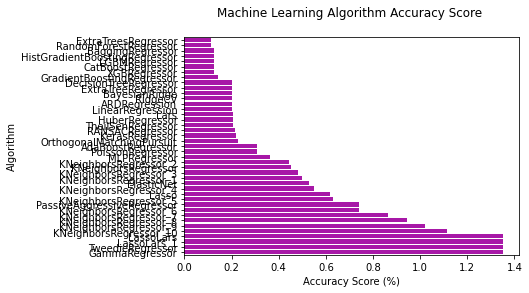

In [21]:
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

# ENSEMBLE CROSS-VALIDATION

In [22]:
# Hill Climbing inspired by code from Kaggle
def hill_climbing(x, y):
    
    # Evaluating oof predictions
    scores = {}
    for col in x.columns:
        scores[col] = median_absolute_error(y, x[col])

    # Sorting the model scores in ascending order
    scores = {k: v for k, v in sorted(scores.items(), key = lambda item: item[1], reverse = False)}

    # Sort oof_df
    x = x[list(scores.keys())]

    # Initialize weights
    weights = {col: 1 if i == 0 else 0 for i, col in enumerate(x.columns)}

    STOP = False
    current_best_ensemble = x.iloc[:,0]
    MODELS = x.iloc[:,1:]
    weight_range = np.arange(-0.5, 0.51, 0.01) 
    history = [median_absolute_error(y, current_best_ensemble)]
    j = 0

    while not STOP:
        j += 1
        potential_new_best_cv_score = median_absolute_error(y, current_best_ensemble)
        k_best, wgt_best = None, None
        for k in MODELS:
            for wgt in weight_range:
                potential_ensemble = (1 - wgt) * current_best_ensemble + wgt * MODELS[k]
                cv_score = median_absolute_error(y, potential_ensemble)
                if cv_score < potential_new_best_cv_score:
                    potential_new_best_cv_score = cv_score
                    k_best, wgt_best = k, wgt

        if k_best is not None:
            # Update weights
            weights = {col: (1 - wgt_best) * weights[col] if col != k_best else wgt_best for col in weights}
            current_best_ensemble = (1 - wgt_best) * current_best_ensemble + wgt_best * MODELS[k_best]
            MODELS.drop(k_best, axis = 1, inplace = True)
            if MODELS.shape[1] == 0:
                STOP = True
            history.append(potential_new_best_cv_score)
        else:
            STOP = True
        
    hill_ens_pred = current_best_ensemble
    
    return hill_ens_pred, weights

In [23]:
def create_submission_file(ids, predictions, filename):
    submission = pd.DataFrame({'id': ids, 'Hardness': predictions})
    submission.to_csv(filename, index=False)

In [24]:
%%time

avg_predictions_scores = []
optuna_weights_scores = []
hill_climb_scores = []
stacked_scores = []
optuna_weights_scores_stack = []
hill_climb_weights = []

for i, (train_index, test_index) in enumerate(cv_split_trial.split(train_new, train[TARGET])):
    X_train, X_test = train_new.iloc[train_index], train_new.iloc[test_index]
    y_train, y_test = train[TARGET].iloc[train_index], train[TARGET].iloc[test_index]

    print(f'Fold {i+1}')
    
    MLA_cv_train_preds = []
    MLA_cv_preds = []
    MLA_cv_preds_dict = {}
    MLA_names = []
    
    suffix = 1
    for alg in MLA:
        MLA_name = alg.__class__.__name__

        # Add suffix if name already exists

        original_MLA_name = MLA_name
        if MLA_name in MLA_names:
        # while MLA_cv_preds.str.contains(MLA_name).any():
            MLA_name = f"{original_MLA_name}_{suffix}"
            suffix += 1
            
        predictor = alg.fit(X_train, y_train)
        pred_train_result = predictor.predict(X_train)
        pred_result = predictor.predict(X_test)

        if original_MLA_name == 'KerasRegressor':
            keras_score = median_absolute_error(y_test, pred_result)
            print(f'The Fold {i+1} Keras score is {keras_score}')

        MLA_cv_train_preds.append(pred_train_result)
        MLA_cv_preds.append(pred_result)
        MLA_cv_preds_dict[MLA_name] = pred_result
        MLA_names.append(MLA_name)

    ##################
    ### Hill Climb ###
    ##################
    hill_climb_pred, hill_climb_weight = hill_climbing(pd.DataFrame(MLA_cv_preds_dict), y_test)
    hill_climb_score = median_absolute_error(y_test, hill_climb_pred)
    hill_climb_scores.append(hill_climb_score)
    hill_climb_weights.append(hill_climb_weight)
    print(f'The Fold {i+1} Hill Climb is {hill_climb_score}')
    print(f'The Fold {i+1} weight is {hill_climb_weight}')
    print()

print()
print(f'The Hill Climbing CV score is ==> {np.mean(hill_climb_scores)}')
print(f'The Hill Climbing weights are ==> {hill_climb_weights}')

Fold 1
109/109 [==============================] - 0s 2ms/step
The Fold 1 Hill Climb is 0.10806171794494945
The Fold 1 weight is {'RandomForestRegressor': 0.6653840605824665, 'ExtraTreesRegressor': 0.28516459739248723, 'HistGradientBoostingRegressor': 0.1056165175527734, 'XGBRegressor': 0.06741479843794068, 'LGBMRegressor': -0.020195999999999374, 'CatBoostRegressor': -0.019999999999999397, 'BaggingRegressor': 0.010200000000000368, 'GradientBoostingRegressor': -0.07350523194167893, 'DecisionTreeRegressor': 0.0, 'ExtraTreeRegressor': 0.02143009677600027, 'HuberRegressor': -0.030899879999999293, 'RidgeCV': 0.0, 'BayesianRidge': 0.0, 'LinearRegression': 0.0, 'ARDRegression': 0.0, 'TheilSenRegressor': 0.0, 'Lars': 0.0, 'RANSACRegressor': 0.0, 'OrthogonalMatchingPursuit': 0.0, 'KerasRegressor': -0.01060895879999943, 'PoissonRegressor': 0.0, 'AdaBoostRegressor': 0.0, 'MLPRegressor': 0.0, 'KNeighborsRegressor_3': 4.4408920985006084e-16, 'KNeighborsRegressor': 4.4408920985006104e-16, 'KNeighbors

In [26]:
# Get average weights for the models from all the folds

average_values = {}

for model in hill_climb_weights:
    for key, value in model.items():
        if key in average_values:
            average_values[key] += value
        else:
            average_values[key] = value

num_models = len(hill_climb_weights)
average_values = {k: v / num_models for k, v in average_values.items()}

# Ensure the new weights sum up to 1
sum = 0

for k, v in average_values.items():
    sum += v

average_values, sum, len(average_values)

({'RandomForestRegressor': 0.25083022198261556,
  'ExtraTreesRegressor': 0.5136870838128184,
  'HistGradientBoostingRegressor': 0.04200516918425809,
  'XGBRegressor': 0.0941844642247074,
  'LGBMRegressor': -0.006731999999999791,
  'CatBoostRegressor': 0.2092394457122476,
  'BaggingRegressor': 0.020395000000000274,
  'GradientBoostingRegressor': -0.13822713000128906,
  'DecisionTreeRegressor': 0.04990885870379368,
  'ExtraTreeRegressor': 0.010442705625000222,
  'HuberRegressor': -0.010299959999999764,
  'RidgeCV': 0.0,
  'BayesianRidge': 0.0,
  'LinearRegression': 0.0,
  'ARDRegression': 0.0,
  'TheilSenRegressor': 0.0,
  'Lars': 0.0,
  'RANSACRegressor': -0.0032999999999998447,
  'OrthogonalMatchingPursuit': 0.0,
  'KerasRegressor': -0.013536319599999671,
  'PoissonRegressor': 0.003333333333333474,
  'AdaBoostRegressor': -0.02193053967749033,
  'MLPRegressor': 0.0,
  'KNeighborsRegressor_3': 2.9605947323337417e-16,
  'KNeighborsRegressor': 2.9605947323337427e-16,
  'KNeighborsRegressor

In [27]:
# Create an ordered dictionary based on the order of models in MLA
ordered_average_values = {}
final_mlas = []

for model_name in MLA_names:        
    if model_name in average_values:
        ordered_average_values[model_name] = average_values[model_name]
    else:
        # Handle case where a model might not be in average_values
        ordered_average_values[model_name] = None

# Now ordered_average_values has the averages in the same order as MLA
ordered_average_values

{'MLPRegressor': 0.0,
 'TheilSenRegressor': 0.0,
 'HuberRegressor': -0.010299959999999764,
 'RANSACRegressor': -0.0032999999999998447,
 'Lasso': 1.4802973661668733e-16,
 'ElasticNet': 1.480297366166872e-16,
 'Lars': 0.0,
 'LassoLars': 2.9605947323337403e-16,
 'OrthogonalMatchingPursuit': 0.0,
 'BayesianRidge': 0.0,
 'ARDRegression': 0.0,
 'TweedieRegressor': 2.9605947323337417e-16,
 'PoissonRegressor': 0.003333333333333474,
 'GammaRegressor': 2.9605947323337427e-16,
 'LassoLars_1': 2.960594732333744e-16,
 'LinearRegression': 0.0,
 'PassiveAggressiveRegressor': 0.0,
 'RidgeCV': 0.0,
 'DecisionTreeRegressor': 0.04990885870379368,
 'ExtraTreeRegressor': 0.010442705625000222,
 'XGBRegressor': 0.0941844642247074,
 'LGBMRegressor': -0.006731999999999791,
 'CatBoostRegressor': 0.2092394457122476,
 'KNeighborsRegressor': 2.9605947323337427e-16,
 'KNeighborsRegressor_2': -0.0033329999999996934,
 'KNeighborsRegressor_3': 2.9605947323337417e-16,
 'KNeighborsRegressor_4': 1.4802973661668714e-16,
 

In [28]:
# Get the ordered weights values as a list to be used for final submission
hill_climb_final_weights = []

for value in ordered_average_values.values():
    hill_climb_final_weights.append(value)

hill_climb_final_weights

[0.0,
 0.0,
 -0.010299959999999764,
 -0.0032999999999998447,
 1.4802973661668733e-16,
 1.480297366166872e-16,
 0.0,
 2.9605947323337403e-16,
 0.0,
 0.0,
 0.0,
 2.9605947323337417e-16,
 0.003333333333333474,
 2.9605947323337427e-16,
 2.960594732333744e-16,
 0.0,
 0.0,
 0.0,
 0.04990885870379368,
 0.010442705625000222,
 0.0941844642247074,
 -0.006731999999999791,
 0.2092394457122476,
 2.9605947323337427e-16,
 -0.0033329999999996934,
 2.9605947323337417e-16,
 1.4802973661668714e-16,
 1.4802973661668728e-16,
 1.480297366166874e-16,
 1.4802973661668748e-16,
 1.4802973661668753e-16,
 1.480297366166865e-16,
 1.4802973661668654e-16,
 0.003332666700000282,
 -0.02193053967749033,
 0.020395000000000274,
 0.5136870838128184,
 -0.13822713000128906,
 0.04200516918425809,
 0.25083022198261556,
 -0.013536319599999671]

In [29]:
%%time
test_predictions = []
# Make predictions on test set
for alg in MLA:
        MLA_name = alg.__class__.__name__
                
        predictor = alg.fit(train_new, train[TARGET])
        pred_result = predictor.predict(test_new)

        test_predictions.append(pred_result)
        print(f'Done with {MLA_name}')

Done with MLPRegressor
Done with TheilSenRegressor
Done with HuberRegressor
Done with RANSACRegressor
Done with Lasso
Done with ElasticNet
Done with Lars
Done with LassoLars
Done with OrthogonalMatchingPursuit
Done with BayesianRidge
Done with ARDRegression
Done with TweedieRegressor
Done with PoissonRegressor
Done with GammaRegressor
Done with LassoLars
Done with LinearRegression
Done with PassiveAggressiveRegressor
Done with RidgeCV
Done with DecisionTreeRegressor
Done with ExtraTreeRegressor
Done with XGBRegressor
Done with LGBMRegressor
Done with CatBoostRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with KNeighborsRegressor
Done with AdaBoostRegressor
Done with BaggingRegressor
Done with ExtraTreesRegressor
Done with 

In [30]:
# Double check that the weights and predictions are the same length
len(test_predictions), len(hill_climb_final_weights)

(41, 41)

In [31]:
weighted_avg_predictions = np.average(test_predictions, axis=0, weights=hill_climb_final_weights)
create_submission_file(test['id'], weighted_avg_predictions, f'submission_{experiment}.csv')

In [32]:
# Get NeuralNetwork only submission
predictor = KerasRegressor(epochs=100, batch_size=32).fit(train_new, train[TARGET])
predictions = predictor.predict(test_new)
create_submission_file(test['id'], predictions, f'submission_keras_model.csv')

217/217 [==============================] - 1s 3ms/step
